In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

第二章案例

In [1]:
from numpy import hstack, zeros, ones 
from numpy.random import rand, randn 
from keras.models import Sequential 
from keras.layers import Dense 
from matplotlib import pyplot

2025-05-24 05:14:50.056954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748063690.304596      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748063690.376713      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 定义一个独立的生成器模型 
def define_generator(latent_dim, n_outputs=2): 
    model = Sequential() 
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', 
input_dim=latent_dim)) 
    model.add(Dense(n_outputs, activation='linear')) 
    return model

In [3]:
# 定义一个独立的判别器模型 
def define_discriminator(n_inputs=2): 
    model = Sequential() 
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', 
input_dim=n_inputs)) 
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model 

In [4]:
# 定义一个完整的生成对抗网络模型，即组合的生成器和判别器模型，以更新生成器 
def define_gan(generator, discriminator): 
    discriminator.trainable = False 
    model = Sequential() 
    model.add(generator) 
    model.add(discriminator) 
    model.compile(loss='binary_crossentropy', optimizer='adam') 
    return model

In [9]:
# 生成带有类标签的n个真实样本 
def generate_real_samples(n): 
    X1 = rand(n) - 0.5 
    X2 = X1 * X1 
    X1 = X1.reshape(n, 1) 
    X2 = X2.reshape(n, 1) 
    X = hstack((X1, X2)) 
    y = ones((n, 1)) 
    return X, y 


In [10]:
# 在隐空间中生成一些点作为生成器的输入 
def generate_latent_points(latent_dim, n): 
    x_input = randn(latent_dim * n) 
    x_input = x_input.reshape(n, latent_dim) 
    return x_input

In [11]:
# 使用生成器生成带有类标签的n个伪造样本 
def generate_fake_samples(generator, latent_dim, n): 
    x_input = generate_latent_points(latent_dim, n) 
    X = generator.predict(x_input) 
    y = zeros((n, 1)) 
    return X, y

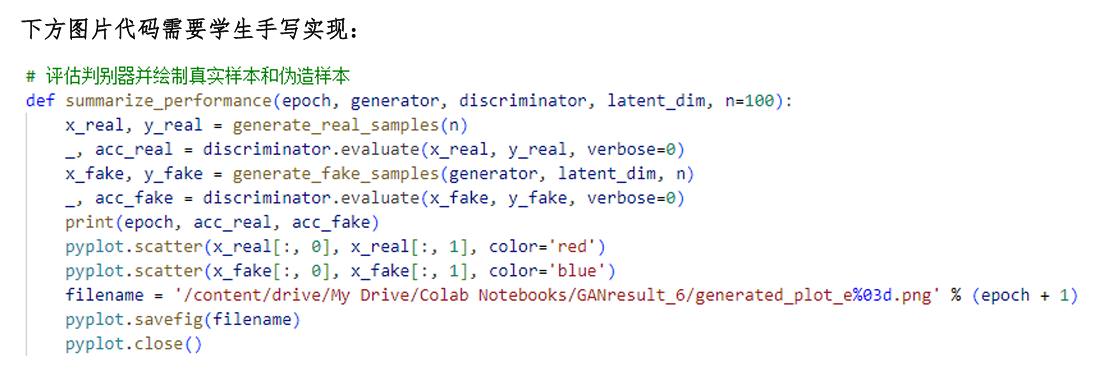


In [15]:
def summarize_performance(epoch,generator,discrimibator,latent_dim,n=100):
    x_real,y_real=generate_real_samples(n)
    _,acc_real =discriminator.evalueate(x_real,y_real,verbose=0)
    x_fake,y_fake = generate_fake_samples(generator,latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake,y_fake,verbose=0)
    print(epoch,acc_real, acc_fake)
    pyplot.scatter(x_real[ :, 0], x_real[ :,1], color='red ' )
    pyplot.scatter(x_fake[ : ,0],x_fake[ :, 1], color='blue ' )
    filename = '/content/drive/Wy Drive/Colab Notebooks/GANresult_6/generated_plot_e%03d.png' %(epoch + 1)
    pyplot.savefig(filename)
    pyplot.close()


# 训练生成对抗网络 
```
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000): 
    half_batch = int(n_batch / 2) 
    for i in range(n_epochs): 
        x_real, y_real = generate_real_samples(half_batch) 
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) 
        d_model.train_on_batch(x_real, y_real) 
        d_model.train_on_batch(x_fake, y_fake) 
        x_gan = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        gan_model.train_on_batch(x_gan, y_gan) 
        if (i + 1) % n_eval == 0: 
            summarize_performance(i, g_model, d_model, latent_dim) 
 
latent_dim = 5 
discriminator = define_discriminator() 
generator = define_generator(latent_dim) 
gan_model = define_gan(generator, discriminator) 
train(generator, discriminator, gan_model, latent_dim)
```


 基于双向LSTM模型的网络攻击检测

# 基于双向LSTM模型的网络攻击检测

## 长短期记忆网络原理简介
 

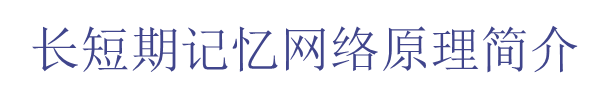
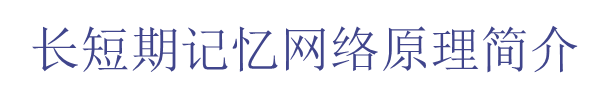
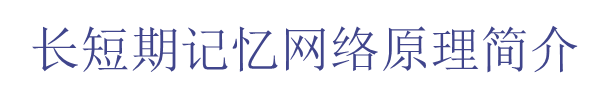
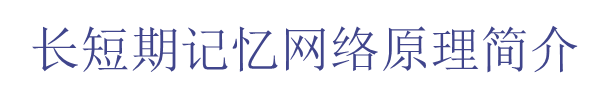

长短期记忆网络是一种特殊的递归神经网络（RNN),旨在解决传统RNN在处理长序列数据时所面临的梯度消失和梯度爆炸问题。LSTM通过引入一组门（Gate)结构来控制值息的流动，从而能够有效地学习并记忆长时间跨度的信息。LSTM的核心部件如下。

1)遗忘门（Forget Gate):决定哪些过去的信息需要被遗忘。通过一个Sigmoid 层，根据入的当前数据和上一个时刻的隐状态，输出一个0-1的值，表示某些信息被遗忘的程度。

2)输入门（ Input Gate):控制哪些新的信息需要被存储到记忆单元中。输入门包含个 Sigmoid 层和一个Tanh层，Sigmoid层决定哪些值需要更新，Tanh层生成候选值，通过这两个层的结合，更新记忆单元的状态。

3)输出门（ Output Gate):决定哪些信息需要被输出。通过一个 Sigmoid 层控制输出，同时结合记忆单元的状态生成最终的输出。

这种设计使LSTM能够保持长期依赖关系，同时在每个时间步中有效地更新记忆，从而适应各种复杂的时间序列任务，如语言模型、语音识别、网络流量分析、网络安全检测等。

双向LSTM模型

1.基本介绍

双向LSTM(Bidirectional LSTM,BiLSTM)是在标准LSTM基础上的改进，旨在更全面地捕捉序列数据中的特征。传统的LSTM仅在时间序列的一个方向上处理数据（通常是从过去到未来）,而双向LSTM在时间序列的两个方向上同时处理数据，即前向和后向。具体来说：前向LSTM从序列的开头到结尾依次处理数据，这个方向的LSTM可以捕捉到从过去到当前时刻的所有依赖关系；后向LSTM从序列的结尾到开头依次处理数据，这个方向的LSTM可以捕捉到从未来到当前时刻的所有依赖关系。

2.实现步骤

双向LSTM的结构由两个相反方向的LSTM层组成，这两个LSTM层的输出通常会在某一层进行合并或连接，形成最终的输出，具体步骤如下。

1)前向LSTM处理：这个LSTM从序列的第一个时间步开始，逐步处理到最后一个时间步。它输出的隐状态包含从过去到当前时间步的所有重要信息。

2)后向LSTM处理：这个LSTM从序列的最后一个时间步开始，逐步处理到第一个时间步。它输出的隐状态包含从未来到当前时间步的所有重要信息。

3)连接层：前向LSTM和后向LSTM的输出在时间维度上合并，通常是将两个输出向量进行拼接或求和，从而形成一个新的输出向量。这个新的输出向量同时包含从过去到当前和从未来到当前的上下文信息。

4)数据预处理：收集网络流量数据，包括正常流量和攻击流量。提取网络流量的特征，如包长度、协议类型、IP头长度、TCP端口号等。将数据标准化，使特征值具有相同的尺度。

5)数据格式转换：将网络流量数据转换为适合LSTM输入的三维格式，通常包括样本数量、时间步长和特征数量。

6)模型创建：创建一个双向LSTM模型，包含前向和后向两个LSTM层，分别处理序列数据的两个方向。在LSTM层之后添加全连接层，用于输出分类结果。

7)模型训练：使用训练数据集训练双向LSTM模型，通过最小化损失函数（如二元交又墙）来优化模型参数。在训练过程中监控模型的准确率和损失，防止过拟合。

8)模型评估：使用测试数据集评估模型的性能，计算准确率、召回率、F1分数等指标。绘制混淆矩阵，展示模型在检测正常流量和攻击流量方面的表现。

9)模型应用：将训练好的双向LSTM模型应用于实时网络流量检测，识别潜在的攻击行为。根据检测结果采取相应的安全措施，如阻止恶意流量、报警等。


利用双向长短期记忆网络(Long Short-Term Memory，LSTM)模型对网络流量进行攻击检测。通过预处理包含攻击和正常流量的数据集，提取特征并标准化后，将数据转换为LSTM输入格式。模型经过训练和验证，达到较高的准确率和召回率。最终，模型识别并分类网络流量中的攻击行为，验证人工智能中的机器学习方法在网络安全中的有效性。 

网络攻击检测的目标是监测网络流量和系统行为，以检测和警告各种类型的网络攻击。它通过分析网络数据包、系统日志、入侵检测系统（IDS）等的警报信息来发现潜在的攻击行为。
（1）基于特征的方法
（2）基于异常的方法
（3）基于统计的方法
（4）基于机器学习的方法 

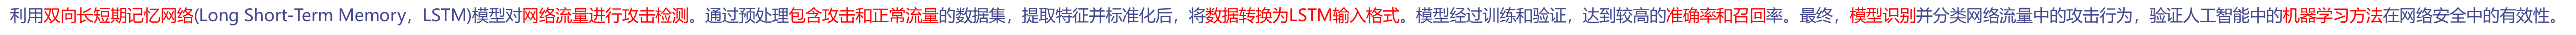
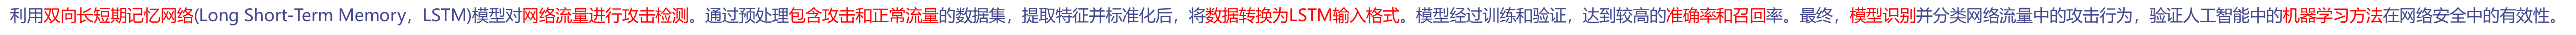
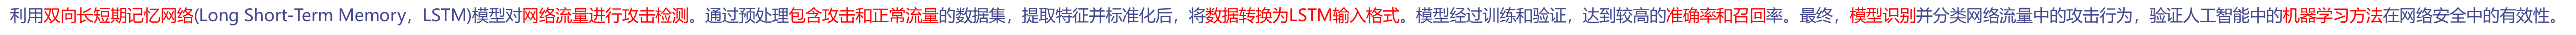
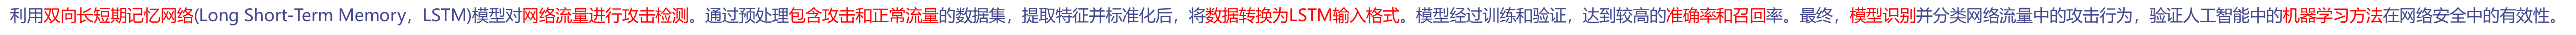
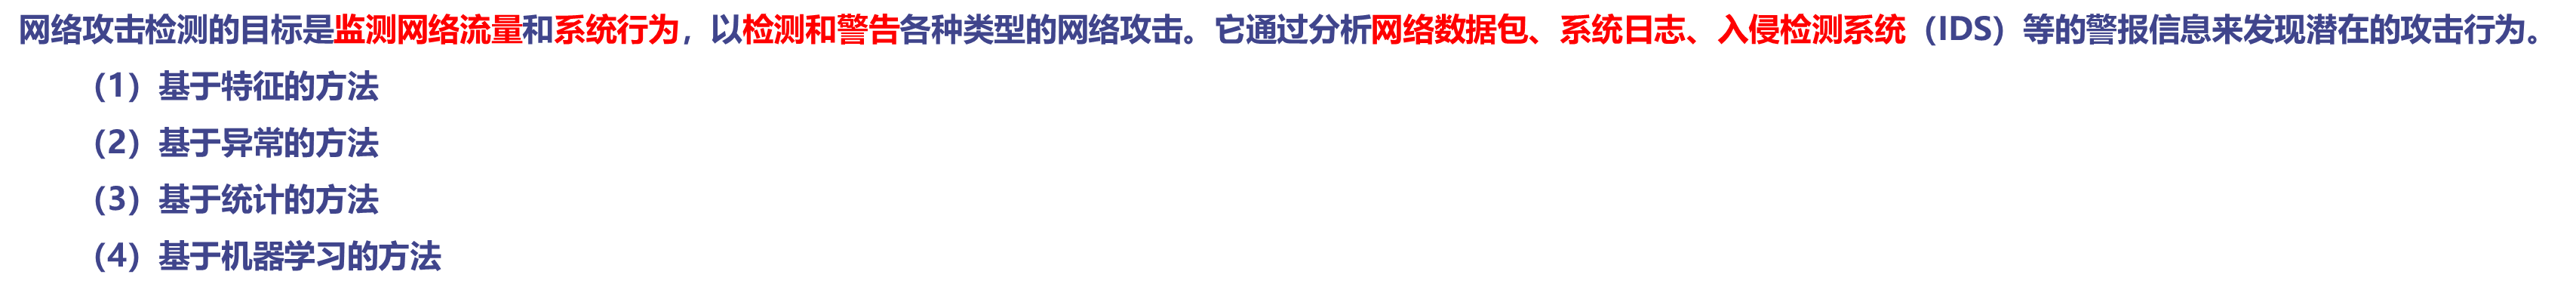
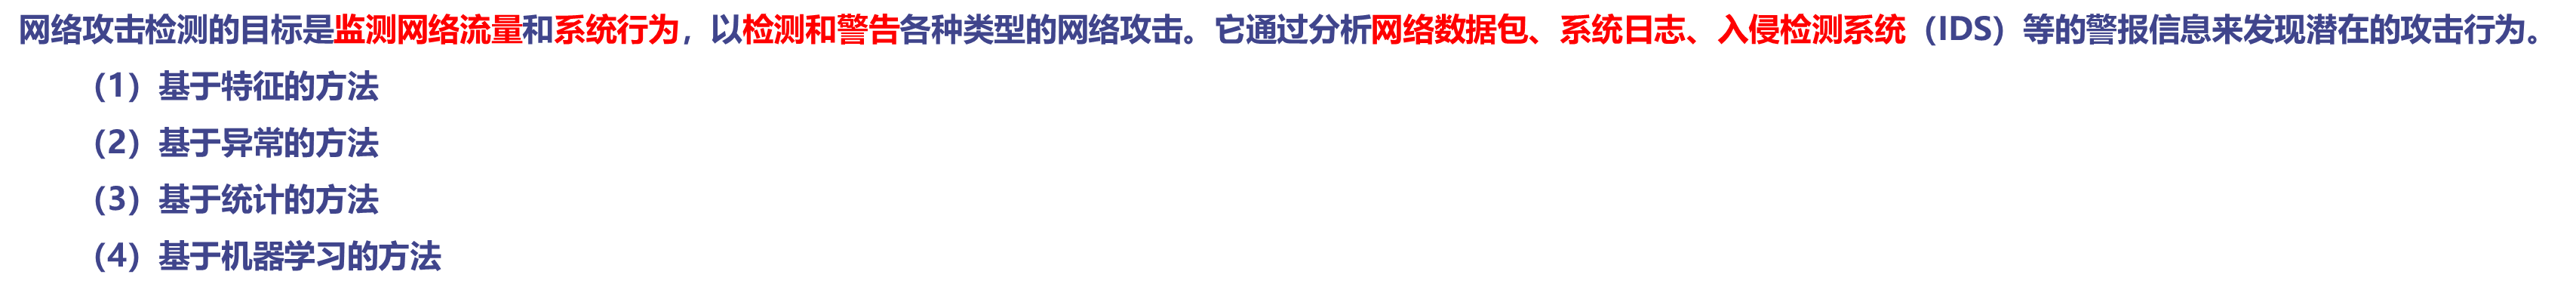
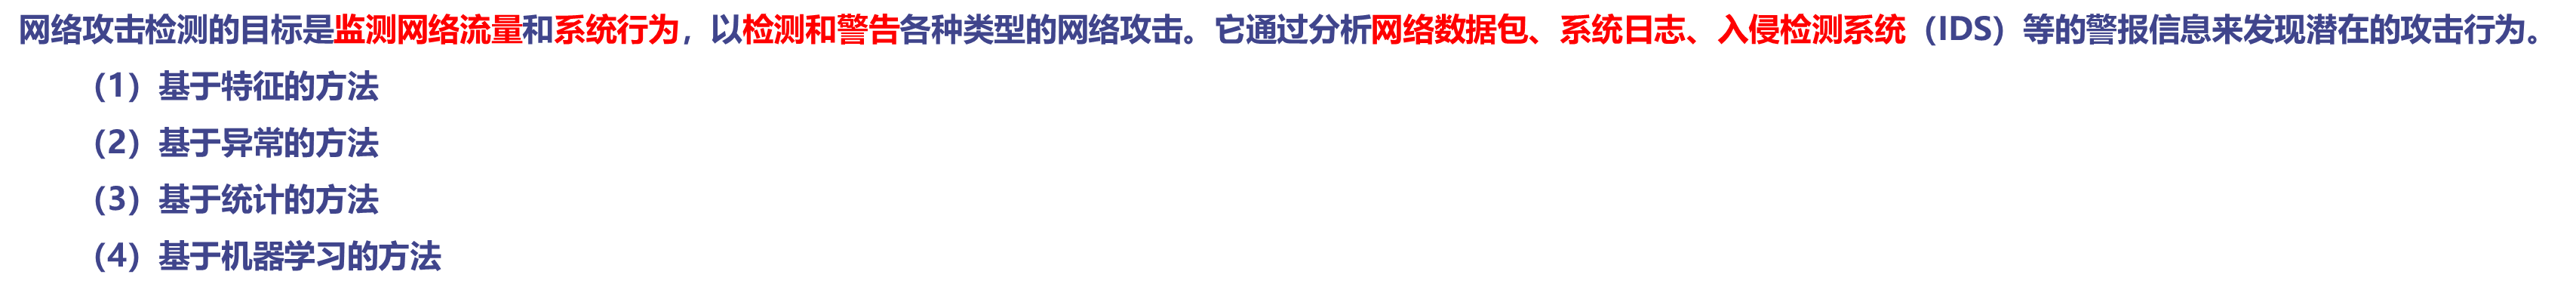
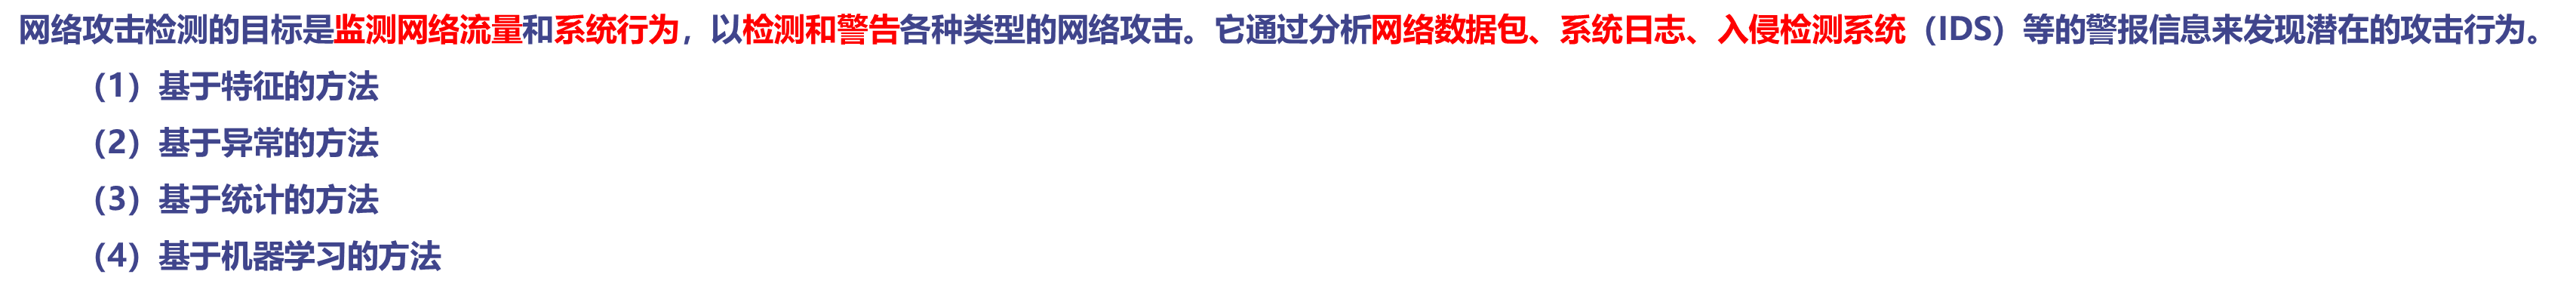

网络攻击检测系统通常包括以下组件：

（1）数据采集：收集网络流量、系统日志和其他相关数据。
（2）数据预处理：对采集到的数据进行清洗、过滤和格式化，以便于后续分析。
（3）分析和检测：应用特征匹配、机器学习、行为分析等技术，对数据进行分析和检测潜在的攻击行为。
（4）警报和响应：当检测到攻击时，发出警报通知相关人员，并触发相应的响应措施，如阻止攻击流量或隔离受感染的系统。 
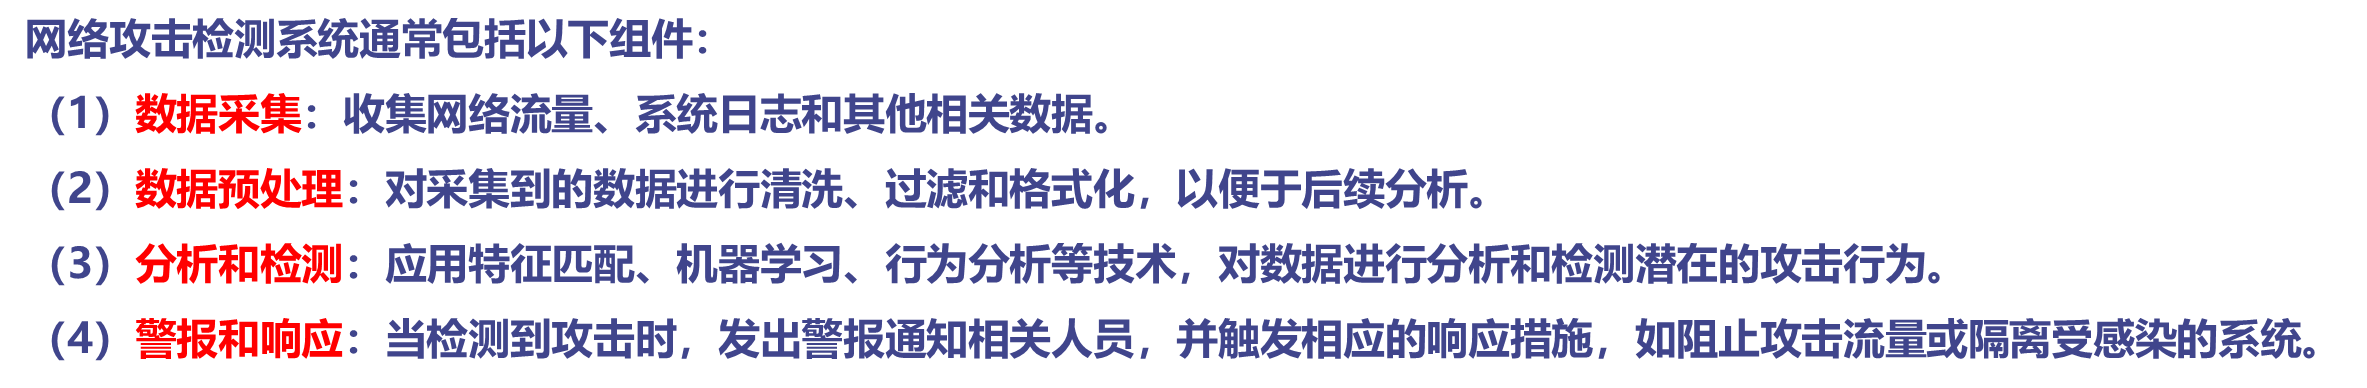
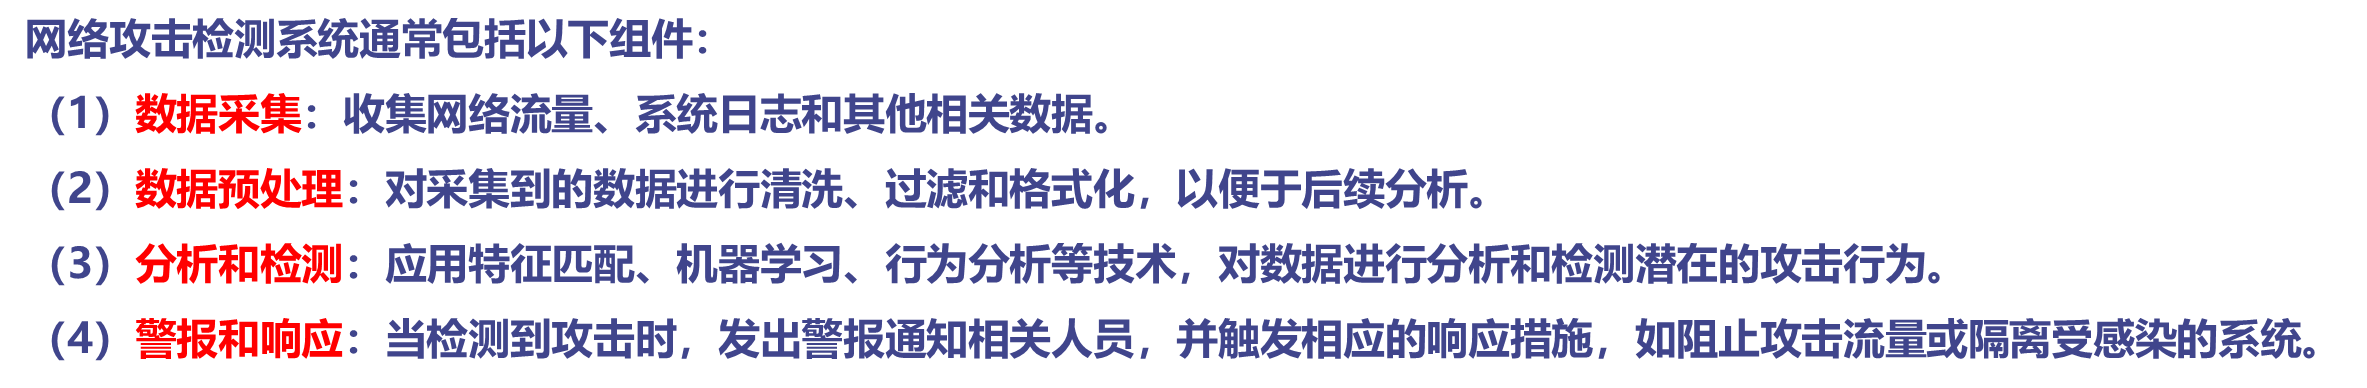
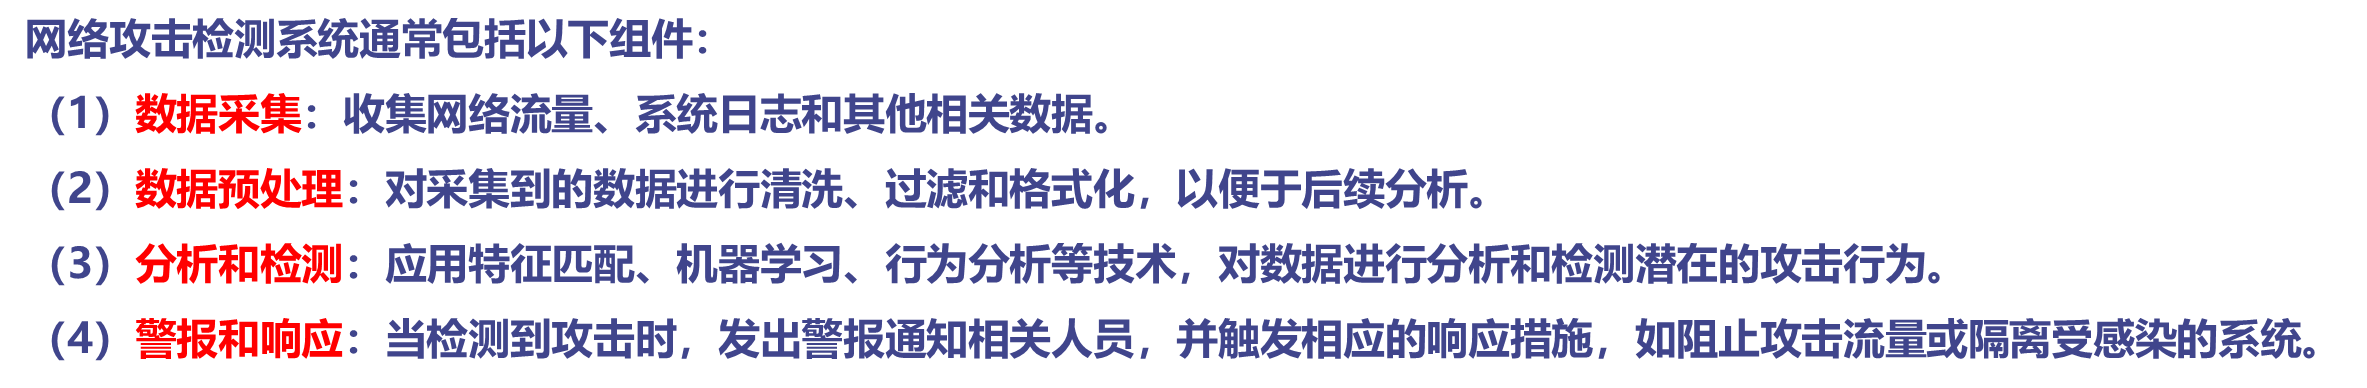
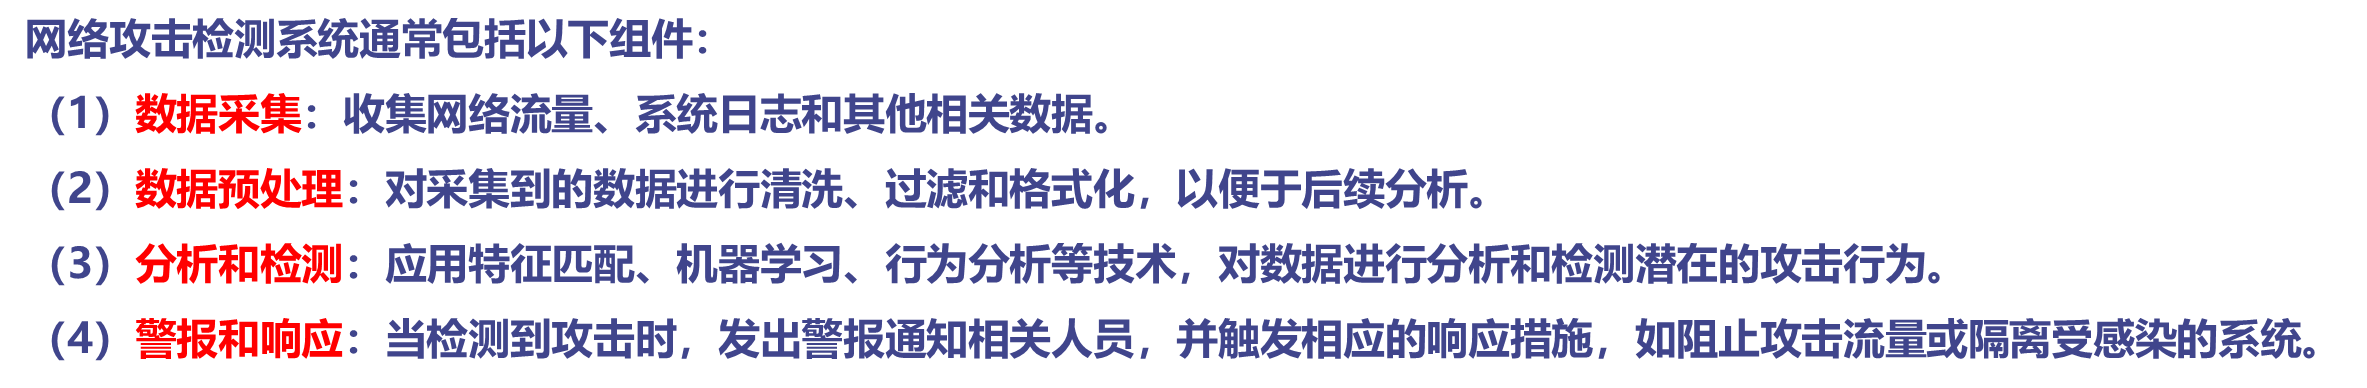

LSTM模型

长短期记忆网络（Long Short-Term Memory，LSTM）是一种特殊的递归神经网络（RNN），旨在解决传统RNN在处理长序列数据时所面临的梯度消失和梯度爆炸问题。LSTM通过引入一组门结构（Gate）来控制信息的流动，从而能够有效地学习并记忆长时间跨度的信息。LSTM的核心部件包括：
（1）遗忘门
（2）输入门
（3）输出门 
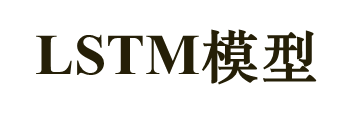
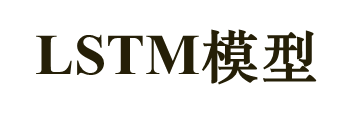
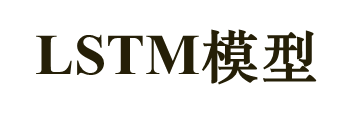
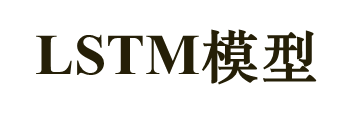
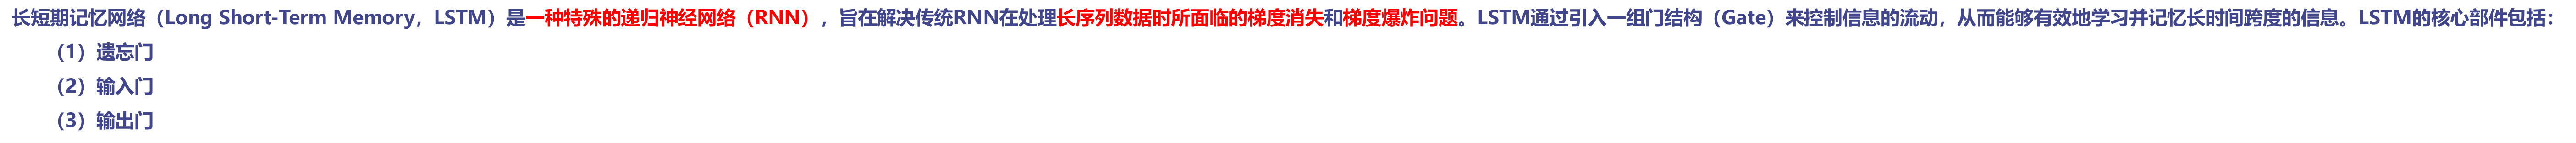
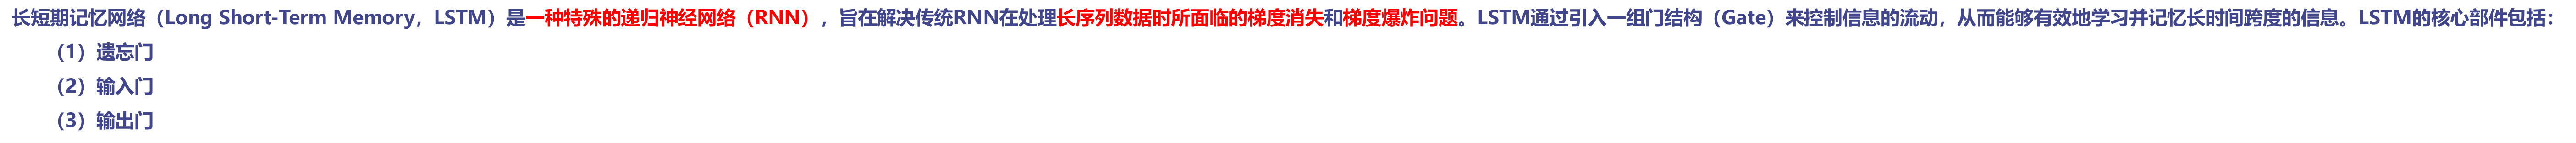
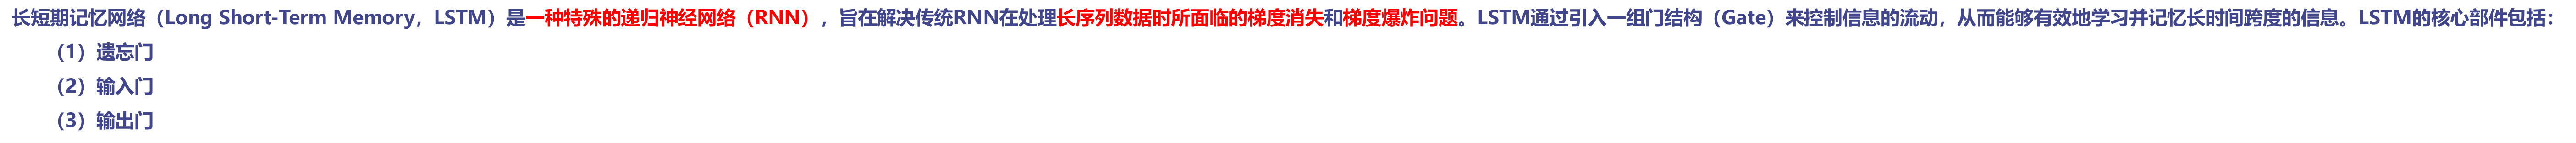
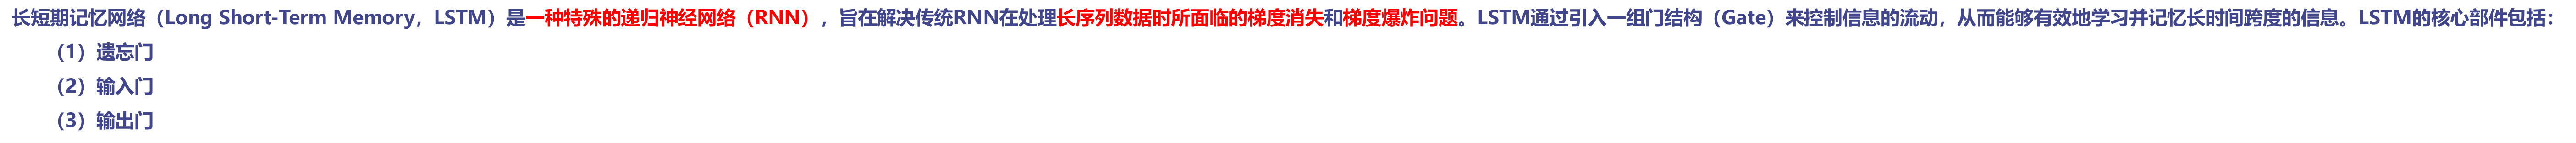

双向LSTM（Bidirectional LSTM, BiLSTM）是在标准LSTM基础上的改进，旨在更全面地捕捉序列数据中的特征。传统的LSTM仅在时间序列的一个方向上处理数据（通常是从过去到未来），而双向LSTM在时间序列的两个方向上同时处理数据，即前向和后向。 
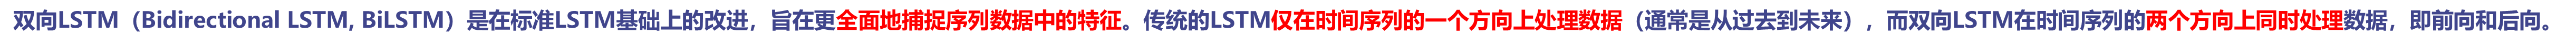
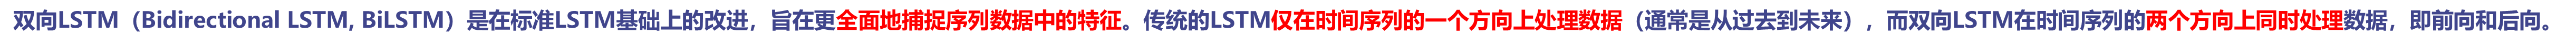
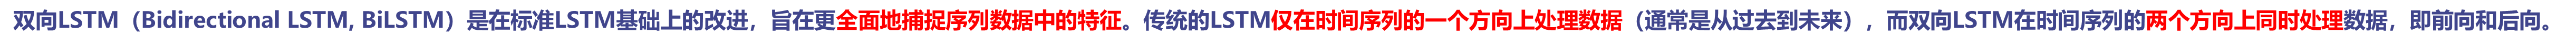
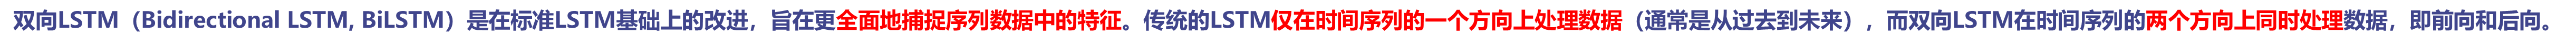

实践的过程如下： 
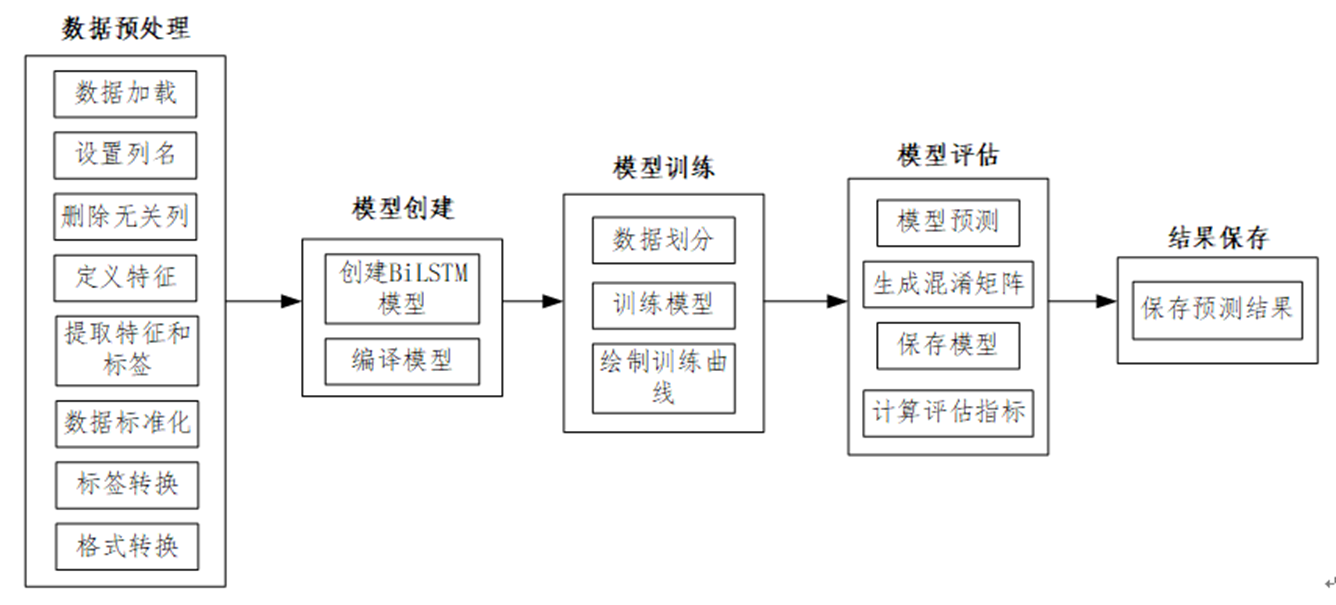 
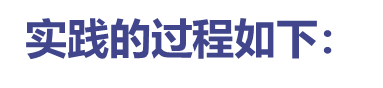
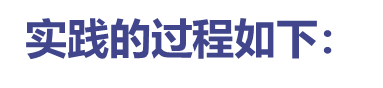
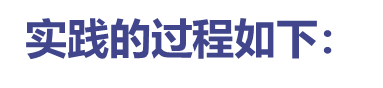
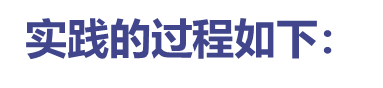
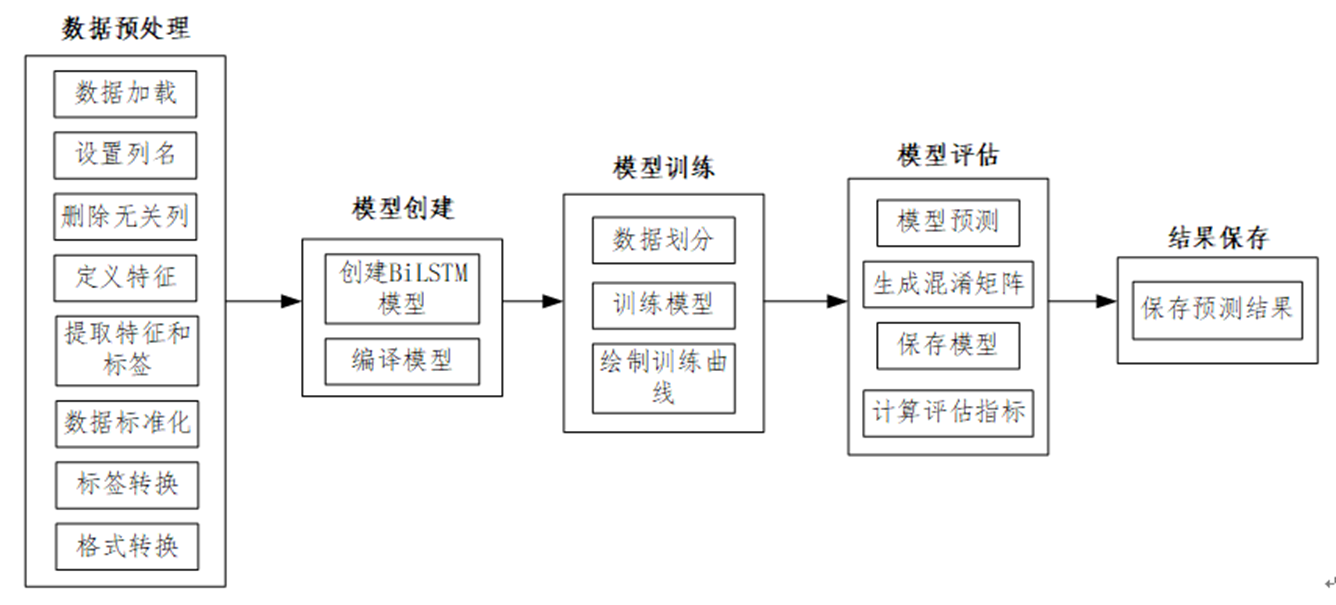

从CSV文件中加载攻击流量和正常流量数据集，各取5000条样本，删除不需要的列，并对特征数据进行标准化处理，将标签转换为二进制格式。

创建一个双向LSTM模型，包括一个双向LSTM层、一个全连接层和一个输出层，使用二元交叉焗作为损失函数、Adam作为优化器进行训练。


使用训练好的模型对测试集进行预测，计算并绘制混淆矩阵，展示模型在检测正常流量和攻击流量方面的表现。


保存训练好的模型及其预测结果，评估模型性能并保存为CSV文件。

第1步：导入相关库和函数 
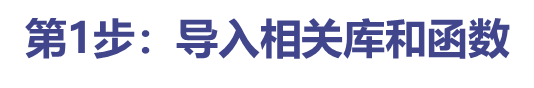
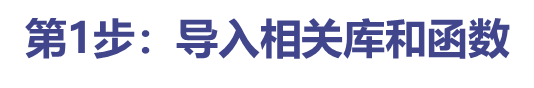
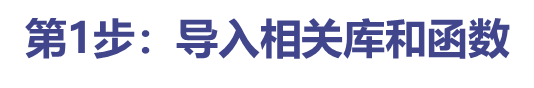
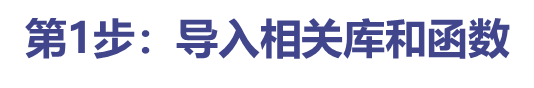

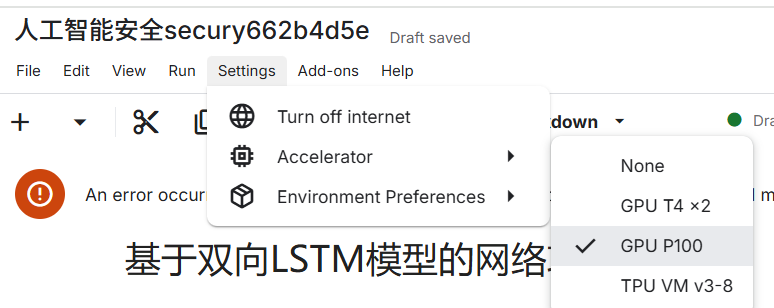

每周可以免费30小时的gpu。

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Bidirectional 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix 
# 定义常量 
#第2步：定义常量
#NUMBER_OF_SAMPLES：定义要从每个数据集中读取的样本数量。
#TRAIN_LEN：定义LSTM模型的输入序列长度（时间步数）。

NUMBER_OF_SAMPLES = 50000 
TRAIN_LEN = 25 
# 数据加载 
#第3步：数据加载
#从CSV文件中加载攻击流量和正常流量的数据集，各取50000条样本。

data_attack = pd.read_csv('/kaggle/input/lstm-attack/dataset_attack.csv', 
nrows=NUMBER_OF_SAMPLES) 
data_normal = pd.read_csv('/kaggle/input/lstm-normal/dataset_normal.csv', 
nrows=NUMBER_OF_SAMPLES) 
# 设置列名 
columns = ['frame.len', 'frame.protocols', 'ip.hdr_len', 'ip.len', 'ip.flags.rb', 'ip.flags.df', 
'p.flags.mf', 
'ip.frag_offset', 'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 
'tcp.dstport', 'tcp.len', 
'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr', 'tcp.flags.ecn', 
'tcp.flags.urg', 
'tcp.flags.ack', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn', 
'tcp.flags.fin', 'tcp.window_size', 
'tcp.time_delta', 'class'] 
data_normal.columns = columns 
data_attack.columns = columns 
# 删除无关列 
drop_columns = ['ip.src', 'ip.dst', 'frame.protocols'] 
data_normal.drop(columns=drop_columns, inplace=True) 
data_attack.drop(columns=drop_columns, inplace=True)

2025-05-24 13:21:02.495612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748092862.766550      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748092862.851942      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


第4步：设置列名

第5步：删除无关列

第6步：定义特征

第7步：提取特征标签X和标签Y

第8步：标准化

第9步：转换标签

第10步：准备LSTM输入数据

第11步：划分训练集和测试集

第12步：创建模型

第13步：训练模型

第14步：绘制准确率和损失图

第15步：模型预测

第16步：混淆矩阵

第17步：保存模型

第18步：评估模型

第19步：保存预测结果 
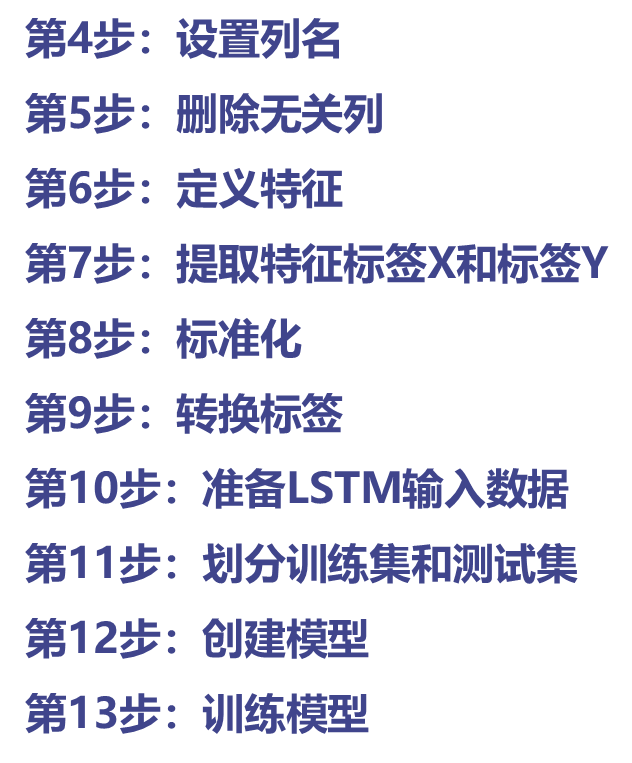
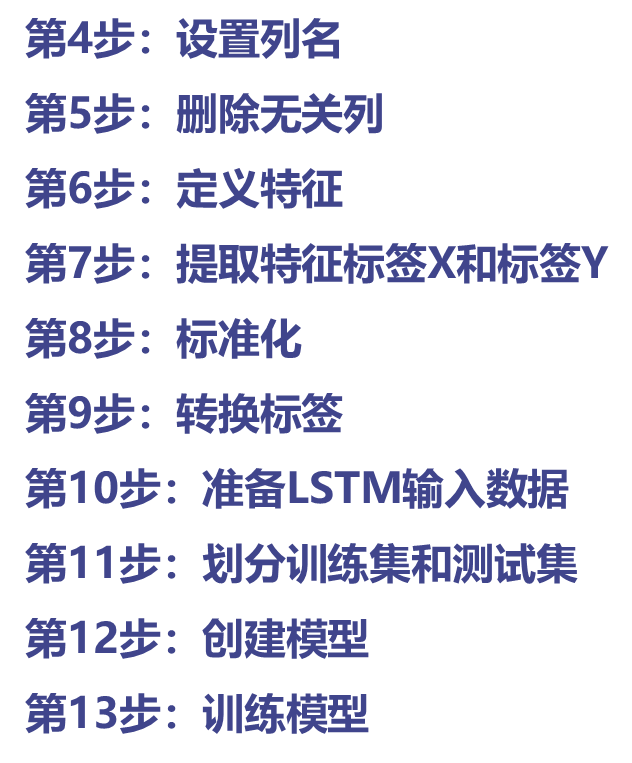
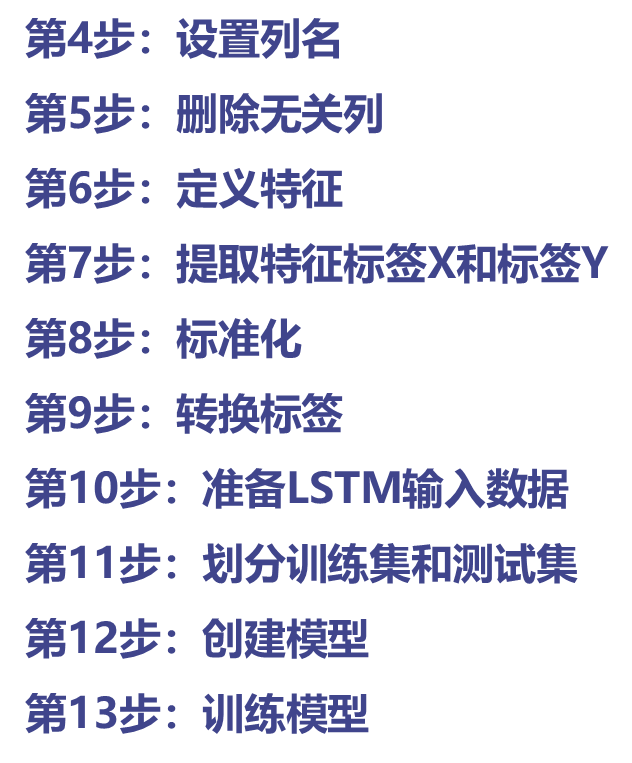
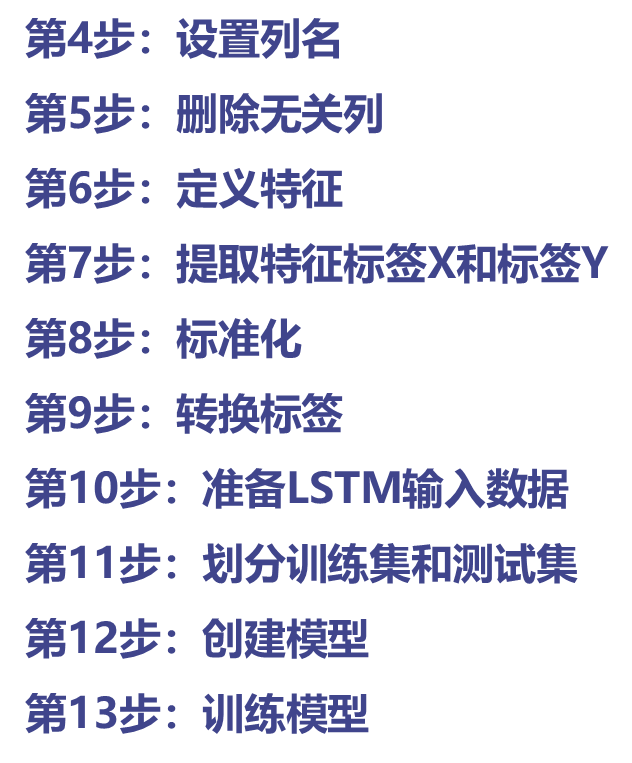
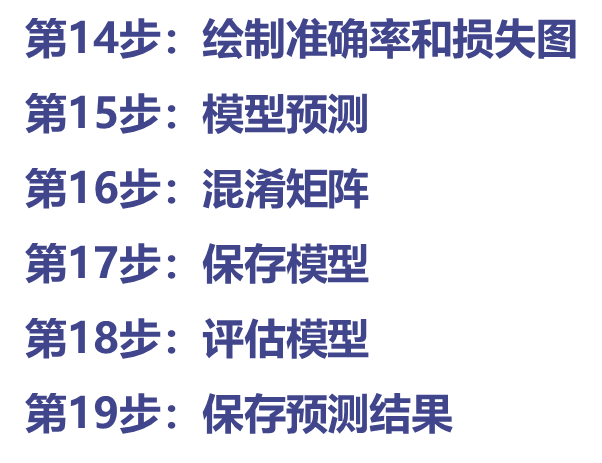
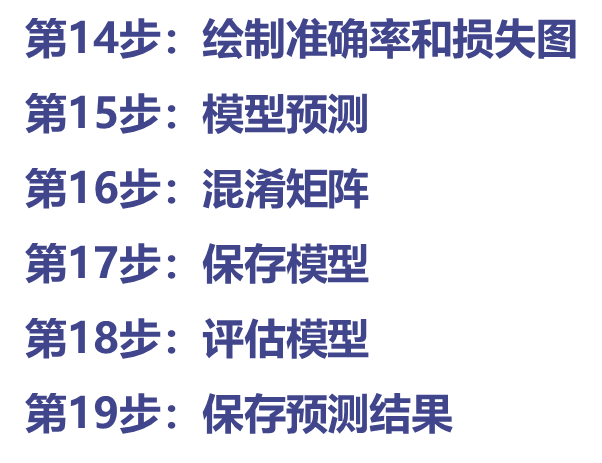
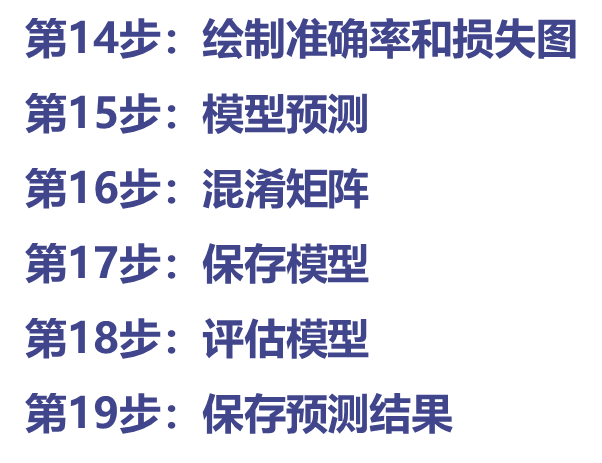
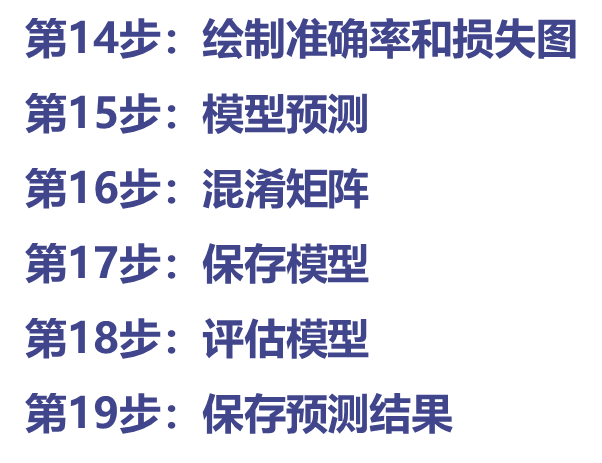

In [3]:
# 定义特征 
features = ['frame.len', 'ip.hdr_len', 'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 
'ip.frag_offset', 
            'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport', 'tcp.len', 'tcp.ack', 
'tcp.flags.res', 'tcp.flags.ns', 
            'tcp.flags.cwr', 'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 
'tcp.flags.push', 'tcp.flags.reset', 
            'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size', 'tcp.time_delta'] 

保存预测结果。

将预测结果转换为 DataFrame,并将0和1映射为attack; normal;提取原始数据集中测试集部分的前10列数据，并将其与预测结果合并，保存为CSV文件 result.csv.

In [4]:
# 提取特征X和标签Y 
X = np.concatenate((data_normal[features].values, data_attack[features].values)) 
Y = np.concatenate((data_normal['class'].values, data_attack['class'].values)) 
 
# 标准化 
scaler = StandardScaler() 
X = scaler.fit_transform(X) 
Y = np.where(Y == "attack", 0, 1) 

In [5]:
# 准备LSTM输入数据 
samples = X.shape[0] 
input_len = samples - TRAIN_LEN 
I = np.array([X[i:i + TRAIN_LEN] for i in range(input_len)]) 
 
# 划分训练集和测试集 
X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(I, 
Y[TRAIN_LEN:], range(len(Y[TRAIN_LEN:])), test_size=0.2, random_state=42) 
 


下方图片代码需要学生手写实现：
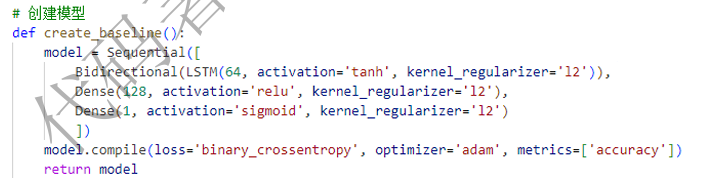


In [18]:
def create_baseline( ):
    model=Sequential([
        Bidirectional(LSTM(64,activation='tanh', kernel_regularizer='l2')),
        Dense(128,activation='relu' , kernel_regularizer='l2'),
        Dense(1,activation='sigmoid', kernel_regularizer='l2')])
    model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])
    return model
model = create_baseline()


In [19]:

# 训练模型 
history = model.fit(X_train, Y_train, epochs=5, validation_split=0.2, verbose=1) 
 


Epoch 1/5


I0000 00:00:1748094070.054724     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9146 - loss: 0.5339 - val_accuracy: 0.9452 - val_loss: 0.1931
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9527 - loss: 0.1850 - val_accuracy: 0.9642 - val_loss: 0.1448
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9604 - loss: 0.1579 - val_accuracy: 0.9649 - val_loss: 0.1457
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9638 - loss: 0.1476 - val_accuracy: 0.9689 - val_loss: 0.1250
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9668 - loss: 0.1371 - val_accuracy: 0.9624 - val_loss: 0.1511


对模型结果进行评估，测试并给出准确率、损失率以及混淆矩阵。

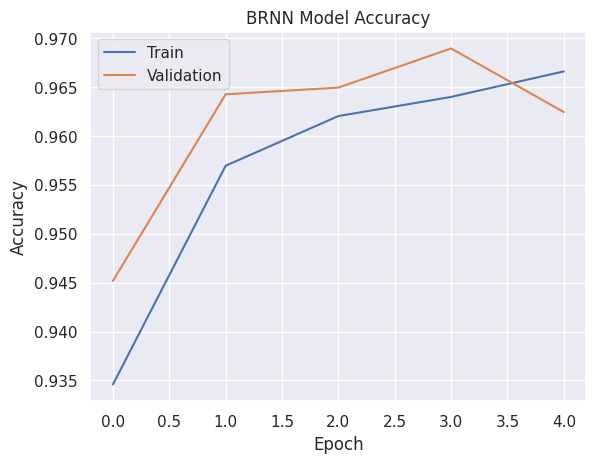

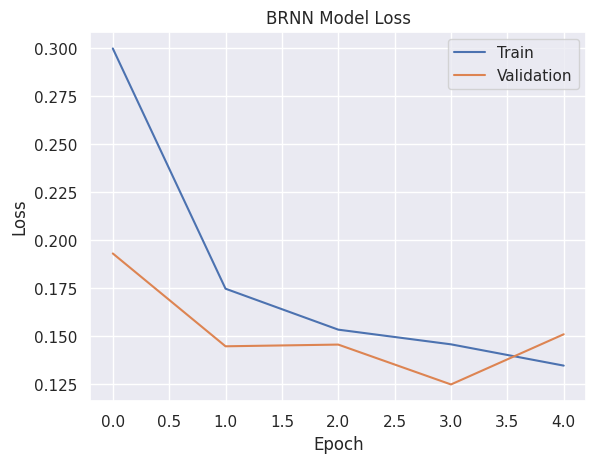

In [20]:
# 绘制准确率和损失图 
def plot_metrics(history, metric, title, ylabel, save_as): 
    plt.figure()
    plt.plot(history.history[metric]) 
    plt.plot(history.history['val_' + metric]) 
    plt.title(title) 
    plt.ylabel(ylabel) 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Validation'], loc='best') 
    plt.savefig(save_as) 
    plt.show() 
plot_metrics(history, 'accuracy', 'BRNN Model Accuracy', 'Accuracy', 'BRNN_Model_Accuracy.png') 
plot_metrics(history, 'loss', 'BRNN Model Loss', 'Loss', 'BRNN_Model_Loss.png') 

1.对模型结果进行评估，测试并给出准确率和损失率以及混淆矩阵
运行brnn_classifier.py文件。

可以看到，模型在测试集上的评估结果为：

准确率 (Accuracy)97.25%，
召回率 (Recall)99%。
 
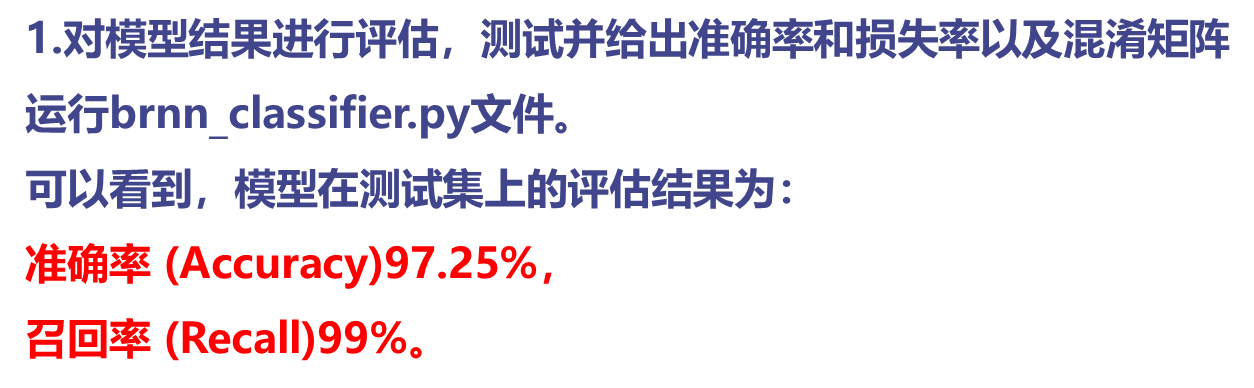
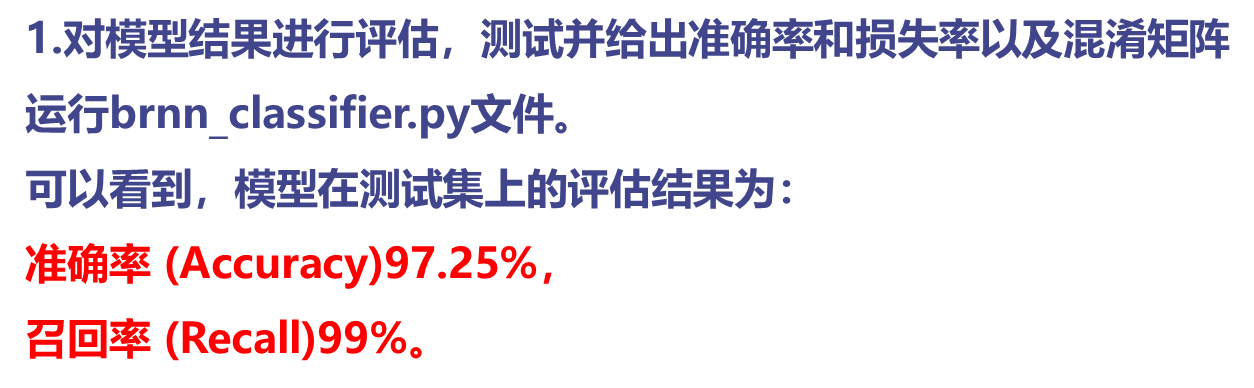
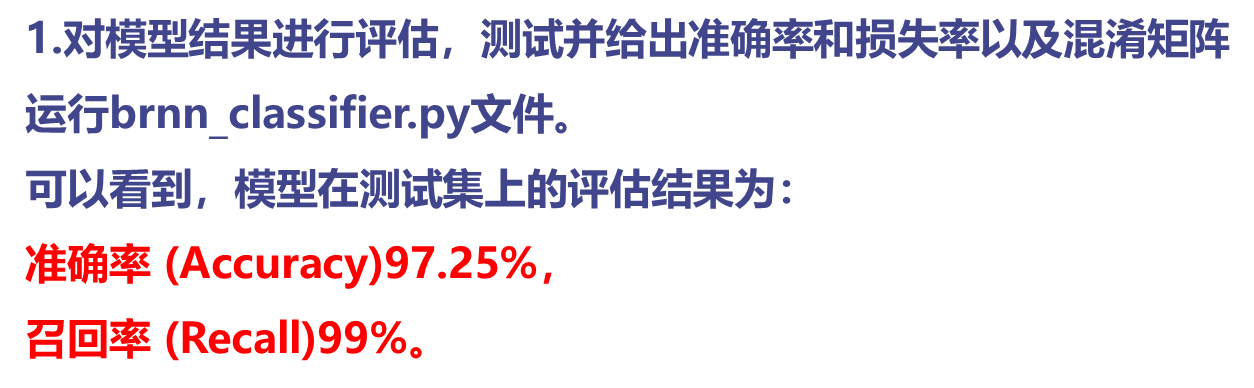
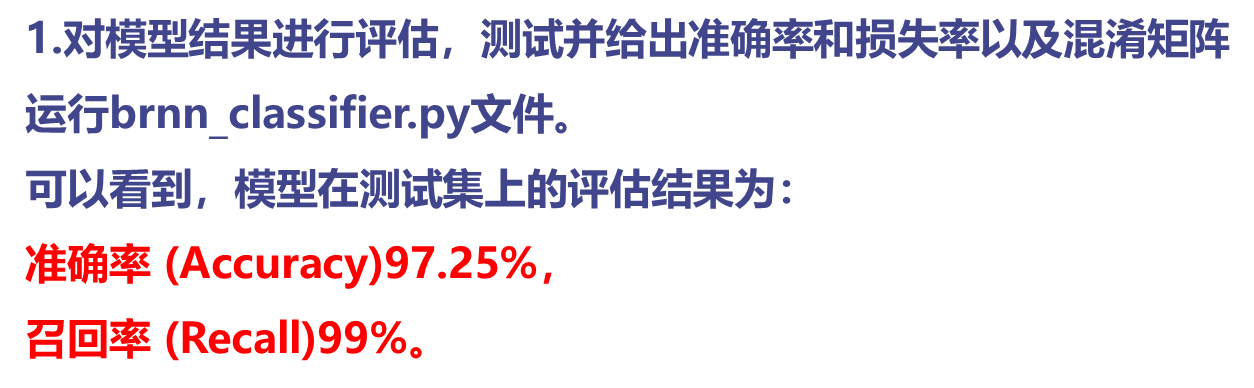

可以看到，模型在测试集上的评估结果为：准确率（Accuracy)为97.25%,召回率(Recall)为99%。准确率和损失的训练过程如图 所示。

训练过程中准确率和验证准确率都在逐渐上升，表明模型在逐步学习并改进其对数据的预测能力。训练损失和验证损失则在逐渐下降，表明模型在减少训练数据和验证数据上的预测误差。

验证准确率和训练准确率都保持在较高水平，并且两者之间的差距不大。这表明模型在验证数据上的表现与在训练数据上的表现相当，没有明显的过拟合现象。验证损失与训练损失在大多数轮次中同步下降，表明模型在验证数据上的误差也在减少，没有明显的过拟合迹象。

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


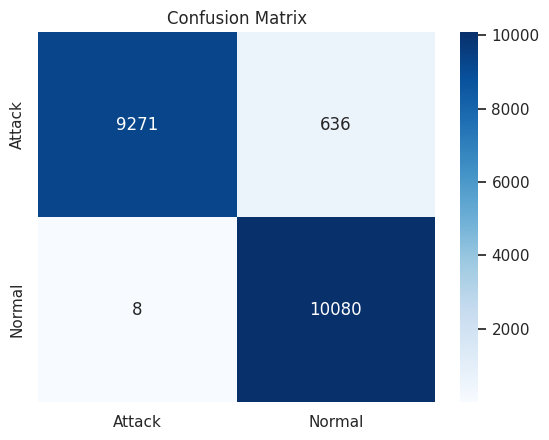

Accuracy: 96.78%
Recall: 1.00


In [21]:
# 模型预测 
predictions = model.predict(X_test, verbose=1).flatten().round() 
# 混淆矩阵 
conf_matrix = confusion_matrix(Y_test, predictions) 
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Attack', 'Normal'], columns=['Attack', 
'Normal']) 
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues') 
plt.title('Confusion Matrix') 
plt.savefig('Confusion_Matrix_BRNN.png', dpi=400) 
plt.show() 
model.save('brnn_model.keras') 
# 评估模型 
scores = model.evaluate(X_test, Y_test, verbose=0) 
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) 
print(f"Accuracy: {scores[1]*100:.2f}%") 
print(f"Recall: {recall:.2f}") 
predictions_df = pd.DataFrame({'Predicted': predictions, 'Actual': Y_test}) 
predictions_df['Predicted'] = predictions_df['Predicted'].map({0: 'attack', 1: 'normal'}) 
predictions_df['Actual'] = predictions_df['Actual'].map({0: 'attack', 1: 'normal'}) 
test_data_subset = pd.concat([data_normal, data_attack]).iloc[test_indices, :10] 
result_df = pd.concat([test_data_subset.reset_index(drop=True), 
predictions_df.reset_index(drop=True)], axis=1) 
result_df.to_csv('result.csv', index=False) 

模型在训练数据上的准确率在逐渐提高，表明模型在有效地学习训练数据的特征。验证准确率也在逐渐提高，最终达到96.80%,这表明模型在未见过的数据上的表现也很好。也就是说，模型在训练过程中表现良好，学习有效，且能够在未见过的数据上保持高性能。生成的混淆矩阵热图如图

In [ ]:
训练过程中准确率的变化：

训练过程中准确率和验证准确率都在逐渐上升，表明模型在逐步学习并改进其对数据的预测能力。


训练过程中损失的变化：

训练损失和验证损失在逐渐下降，表明模型在减少训练数据和验证数据上的预测误差。 
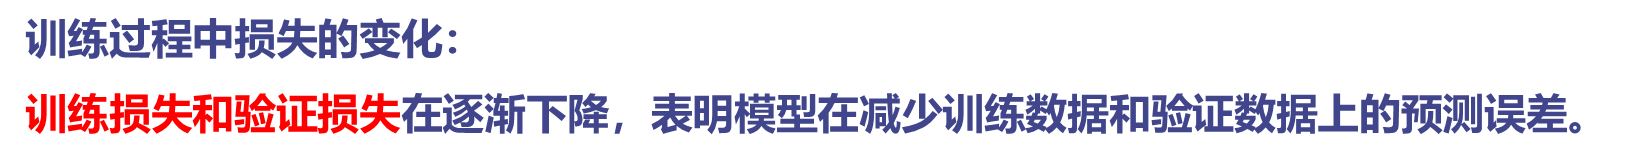
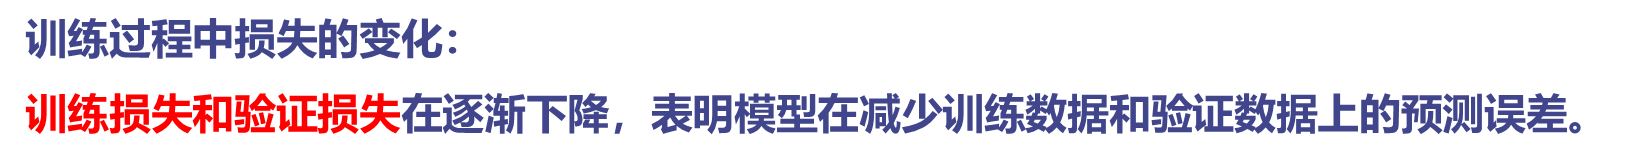
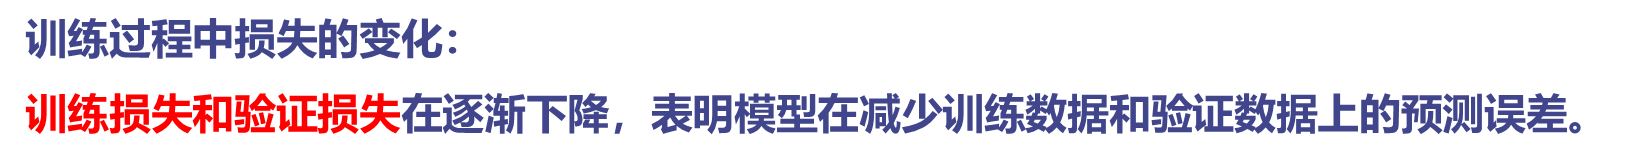
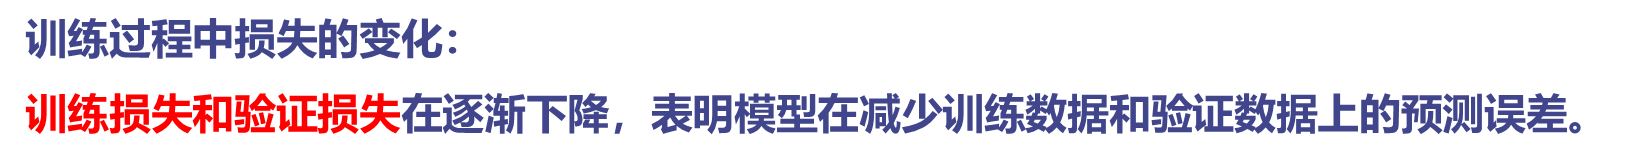

混淆矩阵显示了分类模型在分类任务中的表现，通过对比真实标签和预测标签，评估模型的准确性。从图中可以看到：真正例（True Positive,TP),即模型正确预测为攻击的样本数为9389,假正例（False Positive,FP),即模型错误预测为正常的样本数为518,假负例（False Negative,FN),即模型错误预测为攻击的样本数为39,真负例（True Negative,TN),即模型正确预测为正常的样本数为10049。

根据上面的数据可以计算更精确的模型指标。可以算出，准确率为97.19%,精确率为94.77%,召回率为99.59%,F1分数为97.10%。
从中可以看出，97.19%的准确率表明模型在整体上表现非常好，能够正确分类绝大多数的样本。99.59%的召回率表明模型几乎能够识别所有的攻击样本，漏检率非常低。

94.77%的精确率表明模型预测为攻击的样本中绝大部分确实是攻击。仅有39个正常样本被错误地分类为攻击，表明模型对正常流量的误报率很低。有518个攻击样本被误分类为正常，虽然相对较少，但仍有改进空间。

总的来说，正常（Nomal)类别正确预测的数量和比例非常高，说明模型在识别正常流量方面表现良好。攻击（Allack)类别的召回率为99.59%,意味着儿乎所有的攻击流量都被正确识别。模型在检测攻击流量方面表现非常优秀，具有很高的准确性和召回率。精练李略低于召回率，意味着在减少误报方面还有一定的改进空间。但总体来说，模型对于网络攻击的检测非常有效，几乎没有漏检。

## 参考文献

人工智能安全原理与实践，李剑，机械工业出版社，2024年12月